In [1]:
import shelve
import os
import torch
import warnings
import random
from torch.utils.data import Dataset

In [2]:
os.chdir('/Users/rraj/PythonFunctions/DCNet/')
os.getcwd()

'/Users/rraj/PythonFunctions/DCNet'

In [90]:
class ModelData:
    def read_data(self, data_identifier: str, data_type: str):
        file_path = self.check_identifier(data_identifier)
        
        f = shelve.open(file_path[:-3], 'r')
        if data_type == 'train':
            data = f['train_dict']
        elif data_type == 'test':
            data = f['train_dict']
        else:
            raise Exception("invalid data type requested")
        f.close()
        return data
    
    def check_identifier(self, data_identifier: str):
        file_path = data_identifier
        if 'Data' not in data_identifier:
            file_path = os.path.join(os.getcwd(), 'Data', 'Data-'+data_identifier+'.db')
        
        if not os.path.isfile(file_path):
            raise FileNotFoundError(f"{file_path} not found")
        else:
            return file_path
        
        
    def labels_to_index_dict(self, data: dict):
        return {label : indx for indx, label in enumerate(data.keys())}
    
    def index_to_labels_dict(self, labels_to_index_dict: dict):
        return {indx : label for label, indx in labels_to_index_dict.items()}
    
    def get_nclasses(self, data: dict):
        return len(data.keys())
    
    def get_sample_sizes(self, data: dict, index_to_label_dict: dict):
        sample_sizes = []
        for indx in range(len(data)):
            label = index_to_label_dict.get(indx, None)
            sample_sizes.append(data[label].shape[1])
        return sample_sizes

    def get_max_batch_size(self, sample_sizes: list):
        return min(sample_sizes)*len(sample_sizes)
    
    def get_max_data_dim(self, data: dict):
        data_dims = [values.shape[0] for values in data.values()]
        return max(data_dims)


    

In [91]:
class TrainData(ModelData, Dataset):
    def __init__(self, data_identifier: str):
        self.data = self.read_data(data_identifier, 'train')
        self.nclasses = self.get_nclasses(self.data)
        self.labels_to_index = self.labels_to_index_dict(self.data)
        self.index_to_labels = self.index_to_labels_dict(self.labels_to_index)
        self.sample_sizes = self.get_sample_sizes(self.data, self.index_to_labels)
        self.max_batch_size = self.get_max_batch_size(self.sample_sizes)
        

    def __len__(self):
        total_samples = 0
        for value in self.data.values():
            total_samples += value.shape[1]
        return total_samples
    
    def __getitem__(self, index):
        if isinstance(index, tuple) and len(index) == 2:
            k = self.index_to_labels.get(index[0], None)
            return torch.unsqueeze(torch.from_numpy(self.data[k][:, index[1]]), 0)
        else:
            raise IndexError(f"{index} not supported")
        
    def get_data_dim(self):
        return self.get_max_data_dim(self.data)

In [92]:
class TestData(ModelData, Dataset):
    def __init__(self, data_identifier: str):
        self.data = self.read_data(data_identifier, 'test')
        self.labels_to_index = self.labels_to_index_dict(self.data)
        self.nclasses = self.get_nclasses(self.data)
        self.index_to_labels = self.index_to_labels_dict(self.labels_to_index)
        self.sample_sizes = self.get_sample_sizes(self.data, self.index_to_labels)

    def __len__(self):
        total_samples = 0
        for value in self.data.values():
            total_samples += value.shape[1]
        return total_samples
    
    def __getitem__(self, index):
        if isinstance(index, tuple) and len(index) == 2:
            k = self.index_to_labels.get(index[0], None)
            return torch.unsqueeze(torch.from_numpy(self.data[k][:, index[1]]), 0)
        else:
            raise IndexError(f"{index} not supported")
        
    def get_data_dim(self):
        return self.get_max_data_dim(self.data)
        

In [93]:
class TrainLoader:
    def __init__(self, data_source, batch_size: int = 0, n_iter: int = 1, shuffle: bool = False):
        self.data_source = data_source
        self.n_iter = n_iter
        self.shuffle = shuffle
        self.returned_index = 0
        self.adjusted_batch_size = self.adjust_batch_size(batch_size)
        self.nsamples = self.get_nsamples()
        self.class_indices_r = self.get_randomized_class_indices()
        self.sample_indices_r = self.get_randomized_sample_indices()
        
    def __iter__(self):
        return self
    
    def __next__(self):
        if self.n_iter > 0 and self.returned_index < self.adjusted_batch_size:
            c_indx, s_indx = divmod(self.returned_index, self.nsamples)
            self.returned_index += 1
            self.update_batch()
            if self.shuffle:
                indx = self.class_indices_r[c_indx], random.randrange(self.data_source.sample_sizes[c_indx])
                return self.data_source[indx]
            else:
                indx = self.class_indices_r[c_indx], (self.sample_indices_r[c_indx] + s_indx)
                return self.data_source[indx]
        else:
            raise StopIteration

    def update_batch(self):
        if self.returned_index == self.adjusted_batch_size:
            self.n_iter -= 1
            random.shuffle(self.class_indices_r)
            self.sample_indices_r = self.get_randomized_sample_indices()
            self.returned_index = 0
        
    def adjust_batch_size(self, batch_size: int):
        adjusted_batch_size = min(max(batch_size//self.data_source.nclasses, 1) * self.data_source.nclasses, self.data_source.max_batch_size)
        if adjusted_batch_size != batch_size:
            warnings.warn(f"batch size adjusted to {adjusted_batch_size}")
        return adjusted_batch_size

    def get_nsamples(self):
        return (self.adjusted_batch_size//self.data_source.nclasses)
    
    def get_randomized_class_indices(self):
        class_indices_r = [*range(self.data_source.nclasses)]
        random.shuffle(class_indices_r)
        return class_indices_r
    
    def get_randomized_sample_indices(self):
        sample_indices_r = []
        for indx in self.class_indices_r:
            random_start_limit = self.data_source.sample_sizes[indx] - self.nsamples
            sample_indices_r.append(random.randint(0, random_start_limit))
        return sample_indices_r
    
    def get_batch_size(self):
        return self.adjusted_batch_size

In [94]:
class TestLoader:
    def __init__(self, data_source):
        self.data_source = data_source
        self.returned_class_indx = 0
        self.returned_sample_indx = 0

    def __iter__(self):
        return self
    
    def __next__(self):
        if self.returned_class_indx < self.data_source.nclasses and self.returned_sample_indx < self.data_source.sample_sizes[self.returned_class_indx]:
            indx = self.returned_class_indx, self.returned_sample_indx
            self.returned_sample_indx += 1
            self.update_class()
            return self.data_source[indx]
        else:
            raise StopIteration
    
    def update_class(self):
        if self.returned_sample_indx == self.data_source.sample_sizes[self.returned_class_indx]:
            self.returned_class_indx += 1
            self.returned_sample_indx = 0

    def get_index_to_class_dict(self):
        return self.data_source.index_to_labels
    
    def get_class_to_index_dict(self):
        return self.data_source.labels_to_index

In [10]:
train_inputs = TrainData('May04-2357')
train_loader = TrainLoader(train_inputs, batch_size=128, n_iter=2)
test_inputs = TestData('May04-2357')
test_loader = TestLoader(test_inputs)

In [3]:
import logging
logging.basicConfig(format='%(levelname)s:%(message)s', level=logging.DEBUG)
logging.debug('This message should appear on the console')
logging.info('So should this')
logging.warning('And this, too')

DEBUG:This message should appear on the console
INFO:So should this


In [399]:
import torch
from torch.nn.functional import normalize
from torch.linalg import multi_dot

def get_init_batch(train_inputs: TrainData, n_batches: int=1):
    data_dim = train_inputs.get_data_dim()
    batch_size = int(0.25*len(train_inputs))
    train_loader = TrainLoader(train_inputs, batch_size=batch_size, n_iter=n_batches)
    adjusted_batch_size = train_loader.get_batch_size()
    init_tensor = torch.empty((n_batches, adjusted_batch_size, data_dim))
    for i, input in enumerate(train_loader):
        batch_number, sample_number = divmod(i, adjusted_batch_size)
        init_tensor[batch_number, sample_number, :] = torch.flatten(input, start_dim=0)
    return init_tensor

def get_effective_dim(S: torch.Tensor):
    assert S.dim() == 1, "singular values must be in 1D vector"
    S_n = S**2/torch.sum(S**2)
    n_comp = 0
    for i in range(len(S_n)):
        if torch.sum(S_n[:i]) > 0.95:
            n_comp = i+1
            break
    return n_comp

def randomizer_matrix(m: int, n: int):
    assert m >= n, f"m={m} should be greater than or equal to n={n}"
    _, _, V = torch.pca_lowrank(torch.rand(n, n), q=n)
    if m > n:
        random_matrix = normalize(torch.randn(m-n, n), p=2, dim=1)
        Vc = torch.mm(random_matrix, V)
        return torch.vstack((V, Vc))
    else:
        return V

def input_svd_matrices(init_batch: torch.Tensor):
    _, S, V = torch.pca_lowrank(init_batch)
    effective_dim = get_effective_dim(S)
    return V[:, :effective_dim], S[:effective_dim], effective_dim

def initialize_network_connections(layer_dims: list, data_identifier: str):
    train_inputs = TrainData(data_identifier)
    init_batch = get_init_batch(train_inputs)
    left_matrix, sigma, n = input_svd_matrices(init_batch)
    sigma_r = sigma**(-1/len(layer_dims))
    
    for dim in layer_dims:
        right_matrix = randomizer_matrix(layer_dims[dim], n)
        w = multi_dot([left_matrix, torch.diag(sigma_r), right_matrix.T])
        w_n = normalize(w, p=2.0, dim=1)
        left_matrix = right_matrix
    return None


NameError: name 'TrainData' is not defined

In [96]:
train_inputs = TrainData('May04-2357')
init_tensor = get_init_batch(train_inputs, n_batches=3)
print(init_tensor.shape)

torch.Size([3, 64, 102])


/var/folders/b9/8km7dn7s35bfc4y81hgxnfj9d52_hx/T/ipykernel_43991/2289762838.py:39: UserWarning: batch size adjusted to 64
  warnings.warn(f"batch size adjusted to {adjusted_batch_size}")


In [163]:
from torch import nn

class Hash(nn.Module):
    def __init__(self, input_size: int, hash_length: int):
        super().__init__()
        self.fc = nn.Linear(input_size, hash_length, bias=False)
        self.activation = nn.ReLU()

    def forward(self, x: torch.Tensor):
        assert x.dim() == 3
        out = self.fc(x)
        out = self.activation(out)
        return self.hash_function(torch.sign(out))
    
    def hash_function(self, out: torch.Tensor):
        out_f = torch.flatten(out, end_dim=1)
        hash_values = torch.empty((out_f.shape[0], 1))
        for indx, row in enumerate(out_f):
            hash_values[indx, 0] = sum(v*2**i for i, v in enumerate(reversed(row)))
        return hash_values.reshape(*out.shape[:-1], 1)


class MultiHash(nn.Module):
    def __init__(self, input_size: int, n_heads: int):
        super().__init__()
        self.n_heads = n_heads
        self.input_size = input_size
        self.hash_length = 2*input_size #find optimal number of partitions
    
    def forward(self, x: torch.Tensor):
        hash_tensor = torch.empty((*x.shape[:-1], self.n_heads))
        for head in range(self.n_heads):
            hash_layer = Hash(self.input_size, self.hash_length)
            hash_tensor[:, :, head] = torch.flatten(hash_layer(x), start_dim=1)
        return hash_tensor

    


# implement to get input indices or make sure that at max bach size inputs are generated orederly

In [164]:
a1 = torch.tensor([[[1, 2, 3, 4]]], dtype=torch.float)
a2 = torch.tensor([[[1, 1, 1, 1],[5, 6, 7, 8], [0, 0, 0, 0], [6, 4, 5, 2], [7, 3, 9, 1]]], dtype=torch.float)
a3 = torch.vstack((a2, a2)).reshape(2, 5, 4)

print('------input tensor shapes-----')
print(a1.shape)
print(a2.shape)
print(a3.shape)

hash_layer = Hash(4, 3)

print('------output tensor shapes-----')
print(hash_layer(a1).shape)
print(hash_layer(a2).shape)
print(hash_layer(a3).shape)

hash_pool = MultiHash(4, 3)

print('------hashpool tensor shapes-----')
print(hash_pool(a1).shape)
print(hash_pool(a2).shape)
print(hash_pool(a3).shape)

------input tensor shapes-----
torch.Size([1, 1, 4])
torch.Size([1, 5, 4])
torch.Size([2, 5, 4])
------output tensor shapes-----
torch.Size([1, 1, 1])
torch.Size([1, 5, 1])
torch.Size([2, 5, 1])
------hashpool tensor shapes-----
torch.Size([1, 1, 3])
torch.Size([1, 5, 3])
torch.Size([2, 5, 3])


In [71]:
print(hash_pool(a1))
print("------**------")
print(hash_pool(a2))
print("------**------")
print(hash_pool(a3))


tensor([[[180., 118.,  49.]]], grad_fn=<CopySlices>)
------**------
tensor([[[203.,  73., 212.],
         [203., 129., 214.],
         [  0.,   0.,   0.],
         [203., 217., 179.],
         [203., 155., 215.]]], grad_fn=<CopySlices>)
------**------
tensor([[[ 97., 192., 124.],
         [ 97., 192., 124.],
         [  0.,   0.,   0.],
         [101., 130., 220.],
         [100., 130., 216.]],

        [[ 97., 192., 124.],
         [ 97., 192., 124.],
         [  0.,   0.,   0.],
         [101., 130., 220.],
         [100., 130., 216.]]], grad_fn=<CopySlices>)


In [22]:
inp = torch.rand(1, 2, 3)
torch.flatten(inp, end_dim=1)

tensor([[0.6269, 0.9706, 0.4694],
        [0.7349, 0.6549, 0.6819]])

In [62]:
from torch import nn
from torch.nn.functional import normalize

class ModuleD(nn.Module):
    def __init__(self, W: torch.Tensor, w_lateral: torch.Tensor = torch.empty((0,0)), mode: str='l'):
        super().__init__()
        assert W.dim() == 2, "weight must be a 2D tensor"
        self.mode = mode
        self.fc1 = nn.Linear(W.shape[0], W.shape[1], bias=False)
        self.fc1.weight = torch.nn.Parameter(W.T)
        self.w_recurrent = self.set_recurrent_weights(w_lateral)
        self.fc2 = nn.Linear(W.shape[1], W.shape[1], bias=False)
        self.activation = nn.ReLU()
        self.turn_grads_off()
        
    
    def forward(self, x: torch.Tensor):
        out_ = self.fc1(x)
        self.approximate_recurrence(out_)
        out_ = self.fc2(out_)
        out_f = self.activation(out_)
        self.update_forward_weights(x, out_f) if self.mode == 'l' else None
        return out_f

    def approximate_recurrence(self, s: torch.Tensor):
        # get shape parameters
        m, n = self.fc1.weight.shape
        
        # create the diagonal of the selection matrix
        s_flatten = torch.flatten(s, start_dim=0)
        selection_diag = torch.zeros(len(s_flatten))
        selection_indx = torch.argsort(s_flatten, descending=True)
        selection_diag[selection_indx[:n]] = 1
        
        # Approximate the effect of recurrence in matrix A_m
        A_m = torch.eye(m) + torch.mm(torch.diag(selection_diag), self.w_recurrent) -   torch.diag(selection_diag)
        
        # set the wights of the second linear layer and turn grads off
        self.fc2.weight = torch.nn.Parameter(torch.inverse(A_m))
        self.turn_grads_off()
    
    def set_recurrent_weights(self, w_lateral: torch.Tensor):
        recurrent_weights = w_lateral if w_lateral.numel() else torch.mm(self.fc1.weight, self.fc1.weight.T)
        return recurrent_weights

    def update_forward_weights(self, x: torch.Tensor, y: torch.Tensor):
        pass

    def get_forward_weights(self):
        return self.fc1.weight
    
    def turn_grads_off(self):
        self.fc1.weight.requires_grad = False
        self.fc2.weight.requires_grad = False




In [4]:
E = torch.zeros(4, 4, 5)
Y_hat = {}
Y = {} 

# test on dictionaries where response based on similarity is good approximator of final response

for i, n in enumerate([100, 200, 500, 1000]):
    print(n)
    for j, m in enumerate([100, 200, 500, 1000]):
        for k, sp in enumerate([1, 2, 3, 5, 10]):
            s = 0.01*sp
            for _ in range(100):
                W = torch.randn(n, m)
                W_n = normalize(W, p=2, dim=0)
                y = torch.zeros(1, m)
                ind = torch.randint(0, m, (int(m*s),))
                y[0, ind] = 1
                Y[m] = torch.vstack((Y.get(m, torch.zeros(1, m)), y))
                x = torch.mm(y, W_n.T)
                Y_hat[m] = torch.vstack((Y_hat.get(m, torch.zeros(1, m)), torch.mm(x, W_n)))
                layer = ModuleD(W_n)
                output = layer(x)
                E[i, j, k] += torch.norm(y - output, p='fro')/torch.norm(y, p='fro')


100
200
500
1000


In [7]:
from matplotlib import pyplot as plt

In [5]:
ErrorDict = {}
for i, n in enumerate([100, 200, 500, 1000]):
    for j, m in enumerate([100, 200, 500, 1000]):
        ratio = m/n
        ErrorDict[ratio] = torch.vstack((ErrorDict.get(ratio, torch.empty(1, 5)), E[i, j, :]))
print(ErrorDict.keys())


dict_keys([1.0, 2.0, 5.0, 10.0, 0.5, 2.5, 0.2, 0.4, 0.1])


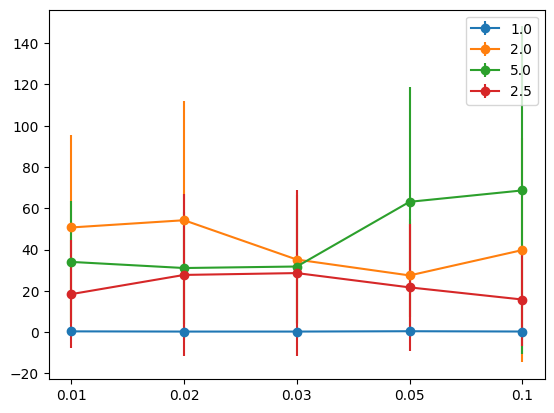

In [13]:
for k, v in ErrorDict.items():
    if k >= 1 and k < 10:
        y_err = 0.01*torch.std(v, dim=0)
        plt.errorbar([*range(5)], 0.01*torch.mean(v, dim=0), label=str(k), yerr = y_err, marker='o')
        plt.xticks(range(5), [0.01, 0.02, 0.03, 0.05, 0.1])
plt.legend()

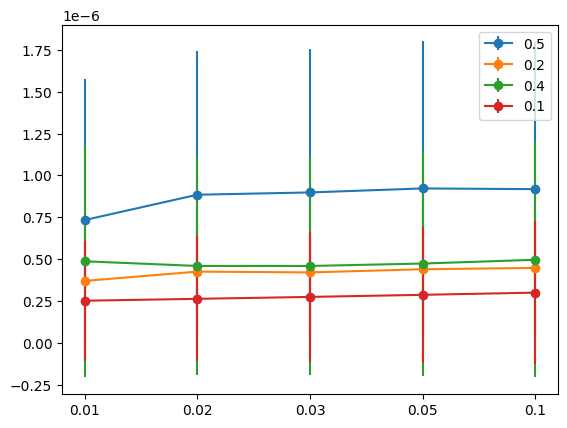

In [9]:
for k, v in ErrorDict.items():
    if k < 1:
        y_err = 0.01*torch.std(v, dim=0)
        plt.errorbar([*range(5)], 0.01*torch.mean(v, dim=0), label=str(k), yerr = y_err, marker='o')
        plt.xticks(range(5), [0.01, 0.02, 0.03, 0.05, 0.1])
plt.legend()

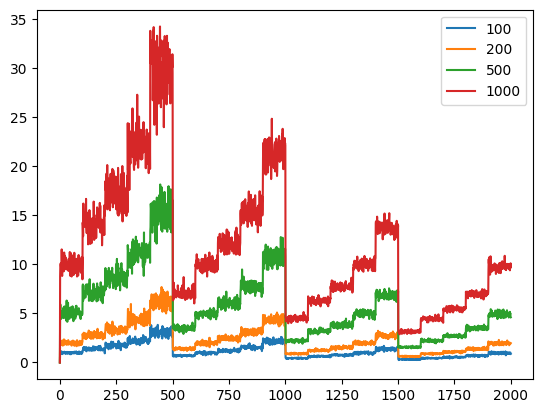

In [185]:
for n in [100, 200, 500, 1000]:
    norm1 = torch.norm((Y[n] - torch.abs(Y_hat[n])), p='fro', dim=1)
    plt.plot(norm1, label=str(n))
plt.legend()

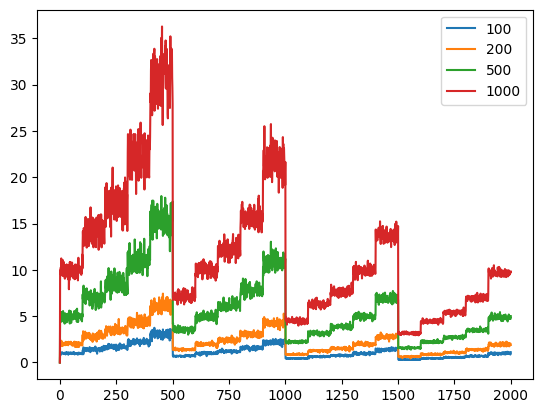

In [10]:
for n in [100, 200, 500, 1000]:
    norm1 = torch.norm((Y[n] - Y_hat[n]), p='fro', dim=1)
    plt.plot(norm1, label=str(n))
plt.legend()

In [46]:
from torch.nn.functional import normalize

def get_sparse_inputs(m: int, s: float):
    y = torch.zeros(1, m)
    ind = torch.randint(0, m, (int(m*s),))
    y[0, ind] = 1
    return y

def get_effective_dim(S: torch.Tensor):
    assert S.dim() == 1, "singular values must be in 1D vector"
    S_n = S**2/torch.sum(S**2)
    n_comp = 0
    for i in range(len(S_n)):
        if torch.sum(S_n[:i]) > 0.95:
            n_comp = i+1
            break
    return n_comp

def randomizer_matrix(m: int, p: int):
    assert m >= p, f"m={m} should be greater than or equal to n={p}"
    _, _, eta = torch.pca_lowrank(torch.rand(p, p), q=p)
    if m > p:
        random_matrix = normalize(torch.randn(m-p, p), p=2, dim=1)
        eta_c = torch.mm(random_matrix, eta)
        return torch.vstack((eta, eta_c))
    else:
        return eta

def input_svd_matrices(init_batch: torch.Tensor):
    assert init_batch.dim() == 2
    _, S, V = torch.pca_lowrank(init_batch, q=min(init_batch.shape))
    effective_dim = get_effective_dim(S)
    return V[:, :effective_dim], S[:effective_dim], effective_dim

In [63]:
from torch.linalg import multi_dot

for i, n in enumerate([100, 200, 500, 1000]):
    print(n)
    for j, m in enumerate([100, 200, 500, 1000]):
        w = torch.empty(1, m)
        for _ in range(n):
            w = torch.vstack((w, get_sparse_inputs(m, 0.01)))
        w = w[1:,:]
        w_n = normalize(w, p=2, dim=0)
        layer = ModuleD(w_n)
        for k, sp in enumerate([1, 2, 3, 5, 10]):
            s = 0.01*sp
            x = get_sparse_inputs(n, s)
            output = layer(x)
            E[i, j, k] += torch.norm(x - torch.mm(output, w_n.T), p='fro')/torch.norm(x, p='fro')


100


_LinAlgError: linalg.inv: The diagonal element 1 is zero, the inversion could not be completed because the input matrix is singular.

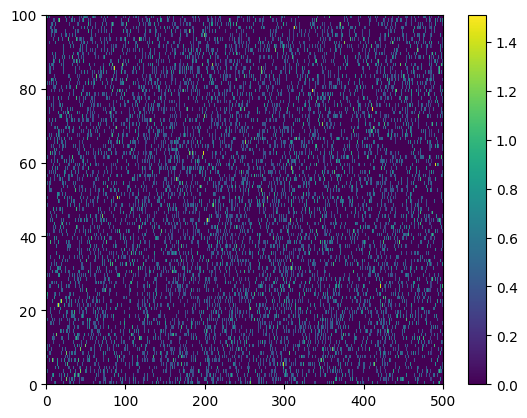

In [59]:
plt.pcolormesh(torch.mm(init_batch, w_n).numpy())
plt.colorbar()

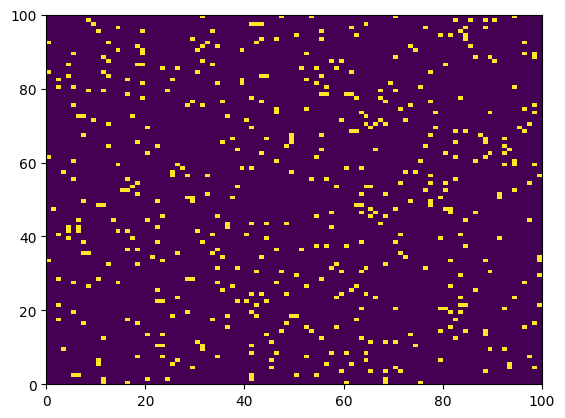

In [54]:
plt.pcolormesh(init_batch.numpy())